In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm

from src.utils.visualization.visualization_utils import set_size, load_colors, initialize_plot
%load_ext autoreload
%autoreload 2
from pyrootutils import pyrootutils
from hydra import initialize, compose
from os import path
import os
root = pyrootutils.setup_root(os.path.abspath(''), indicator=".project-root", pythonpath=True)

from src.systems.systems.dynamic_system import VanDerPolType
from src.utils.visualization.run_plotter import RunPlotter, MultiRunPlotter
from src.systems.runner.predict_test_runner import PredictTestRunner
from src.systems.enviroment.trajectory_replay_env import TrajectoryReplay
from src.data.dataset.base import BasePckHdf5Loader
from src.modules.nd_cnp import NdCNP
from src.systems.predictor.moving_window_nn_predictor import MovingWindowNNPredictor
from src.systems.systems.NNModel import NNModel
import pickle
from typing import List
from src.systems.runner.predict_test_runner import EnvRunResult
import torch


config_path = os.path.relpath(os.path.join(root, "configs"), os.path.abspath(''))
with initialize(version_base=None, config_path=config_path):
    cfg = compose(overrides=[], config_name="notebook")

c = load_colors()
params = initialize_plot('README')  # specifies font size etc., adjust accordingly
plt.rcParams.update(params)

In [2]:
plotter = MultiRunPlotter(VanDerPolType())
runs = plotter.load_pkl([
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_5/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_20/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_50/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_70/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_100/predictor_test__results.pkl.gzip"),
    #os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_200/predictor_test__results.pkl.gzip"),
    #os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_250/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_300/predictor_test__results.pkl.gzip"),

])


(5.507126055071261, 4.095441089282665)


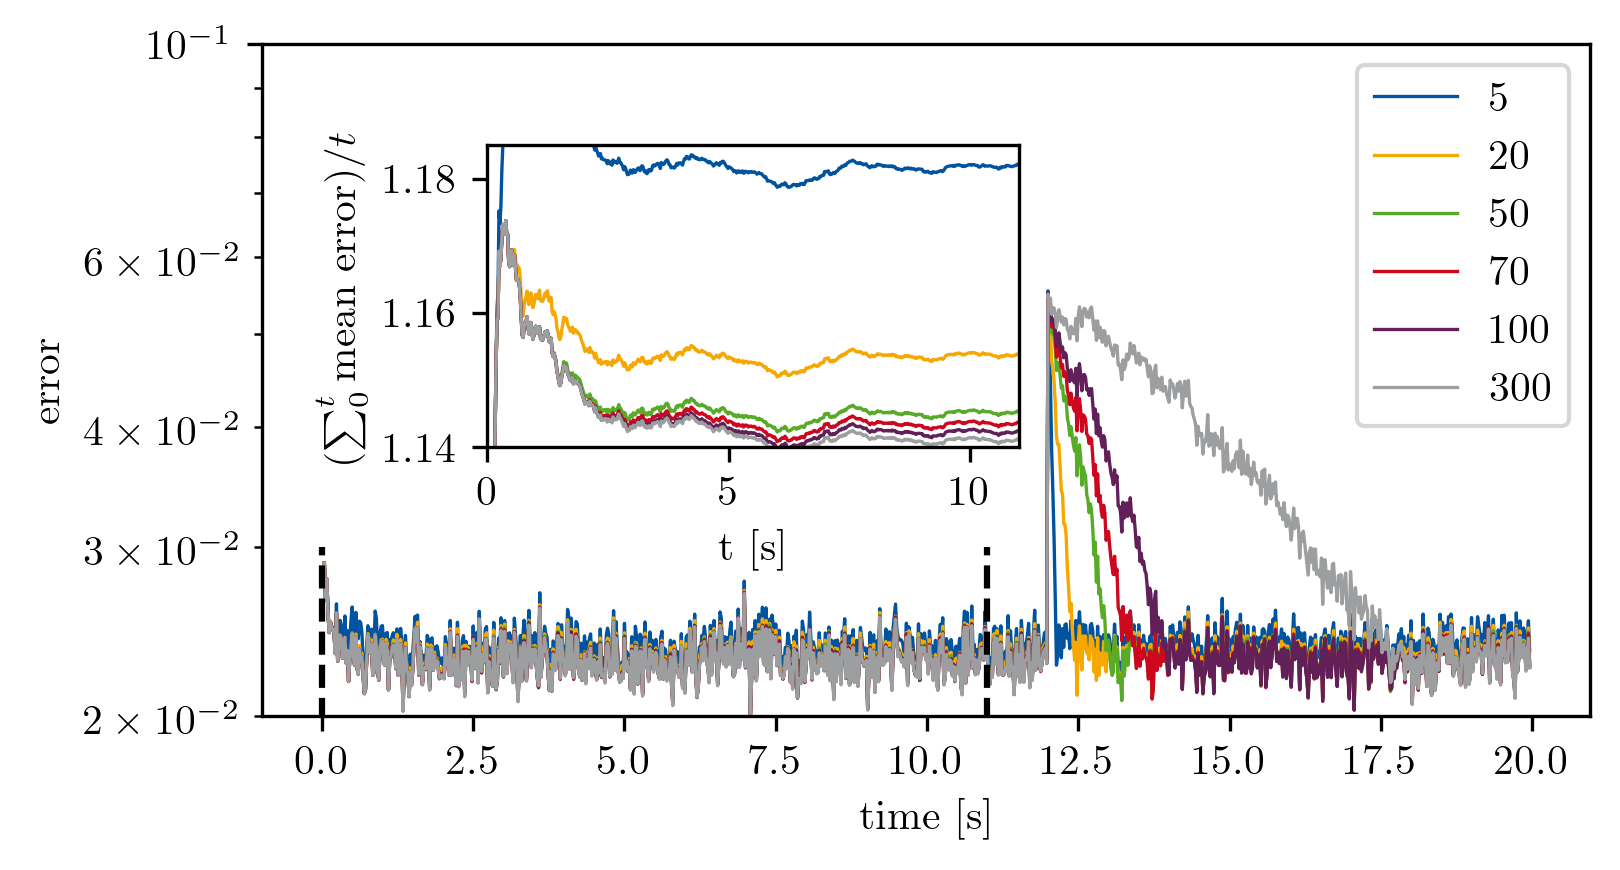

In [3]:
delta_t = 0.02
linewidth = 0.8
labels = ["5", "20", "50", "70", "100", "300"]
print(set_size(width_pt=398, fraction=1, subplots=(1, 1)))
#(5.5, 4)
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3), dpi=300)
ax.set_xlabel("time [s]")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_ylim(0.02, 0.1)
cum_axs = ax.inset_axes([0.17,0.4,0.4,0.45])
cum_axs.set_xlabel("t [s]")
cum_axs.set_ylabel("$(\sum_0^t \\text{mean error}) / t$")
cum_axs.set_xlim(0, 11)
cum_axs.set_ylim(1.14, 1.185)
#cum_axs.set_yscale("log")

time = torch.arange(2 * delta_t, runs[0][0].prediction.error.toSystem.size(0) * delta_t, delta_t)

to_pickle_data = {
    "time": time,
    "mean": [],
    "cum_mean": [],
    "labels": labels
}

for i, run in enumerate(runs):
    errors = [res.prediction.error.toSystem for res in run]
    errors = torch.stack(errors)
    errors = errors[:, 2:]
    errors  = errors / torch.tensor(VanDerPolType().inc_std)
    mean = errors.mean(dim=(0,2))
    ax.plot(time, mean, label=labels[i], linewidth=linewidth)

    cum_means = mean.cumsum(dim=0)
    time_normalized_cum_means = cum_means / time
    cum_axs.plot(time, time_normalized_cum_means, label=labels[i], linewidth=linewidth)
    
    to_pickle_data["mean"].append(mean)
    to_pickle_data["cum_mean"].append(time_normalized_cum_means)

ax.vlines(0, min(mean), 0.03, color="black", linestyle="dashed")
ax.vlines(11, min(mean), 0.03, color="black", linestyle="dashed")

ax.legend()
fig.tight_layout()
fig.savefig("/tmp/oneChangeLarge-vdp-winSizeSweep.pdf")

with open("/tmp/oneChangeLarge-vdp-winSizeSweep.pkl", "wb") as f:
    pickle.dump(to_pickle_data, f)